# Exploratory Data Analysis (EDA) of the Food Deserts in the United States

#### Notes:
 This notebook will give me a better understanding of the data and the problem at hand. I will be using the following datasets:
 
 ##### 1. Food Environment Atlas

The Food Environment Atlas is a collection of datasets that provides a spatial overview of a community's ability to access healthy food and its success in doing so. The Atlas assembles statistics on three broad categories: food choices, health and well-being, and community characteristics. The food environment factors include store/restaurant proximity, food prices, food and nutrition assistance programs, and community characteristics. The health-related factors include access to medical care, environmental conditions, and behaviors that influence health. The community characteristics include demographic composition, cultural attributes, and economic conditions. The Atlas was developed by the United States Department of Agriculture's Economic Research Service, with support from the University of Illinois at Urbana-Champaign.

### The data dictionary is located [here](../data/DataDictionary.csv)

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# EDA

In [22]:
#Imports

#Load the data
df = pd.read_csv('../data/Food Access Research Atlas.csv')
df.head()

,CensusTract,State,County,Urban,Pop2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP
0,1001020100,Alabama,Autauga County,1,1912,693,0,0.0,0.00,0,...,221.0,1622.0,217.0,14.0,0.0,14.0,45.0,44.0,6.0,102.0
1,1001020200,Alabama,Autauga County,1,2170,743,0,181.0,8.34,1,...,214.0,888.0,1217.0,5.0,0.0,5.0,55.0,75.0,89.0,156.0
2,1001020300,Alabama,Autauga County,1,3373,1256,0,0.0,0.00,0,...,439.0,2576.0,647.0,17.0,5.0,11.0,117.0,87.0,99.0,172.0
3,1001020400,Alabama,Autauga County,1,4386,1722,0,0.0,0.00,0,...,904.0,4086.0,193.0,18.0,4.0,11.0,74.0,85.0,21.0,98.0
4,1001020500,Alabama,Autauga County,1,10766,4082,0,181.0,1.68,0,...,1126.0,8666.0,1437.0,296.0,9.0,48.0,310.0,355.0,230.0,339.0


In [3]:
print(df.isnull().sum())

CensusTract      0
State            0
County           0
Urban            0
Pop2010          0
                ..
TractAIAN        4
TractOMultir     4
TractHispanic    4
TractHUNV        4
TractSNAP        4
Length: 147, dtype: int64


        CensusTract         Urban       Pop2010       OHU2010  \
count  7.253100e+04  72531.000000  72531.000000  72531.000000   
mean   2.782573e+10      0.760626   4256.739022   1609.191821   
std    1.581647e+10      0.426704   1955.987626    725.676046   
min    1.001020e+09      0.000000      1.000000      0.000000   
25%    1.212708e+10      1.000000   2899.000000   1108.000000   
50%    2.712979e+10      1.000000   4011.000000   1525.000000   
75%    4.103900e+10      1.000000   5330.500000   2021.000000   
max    5.604595e+10      1.000000  37452.000000  16043.000000   

       GroupQuartersFlag      NUMGQTRS      PCTGQTRS  LILATracts_1And10  \
count       72531.000000  72506.000000  72506.000000       72531.000000   
mean            0.007114    110.121549      2.708677           0.128125   
std             0.084046    443.931753      9.570875           0.334231   
min             0.000000      0.000000      0.000000           0.000000   
25%             0.000000      0.000000 

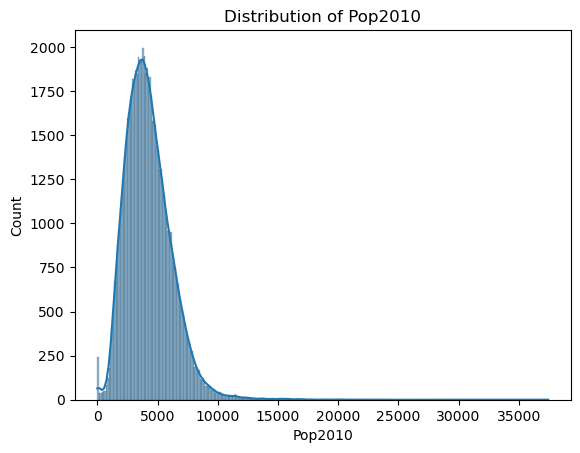

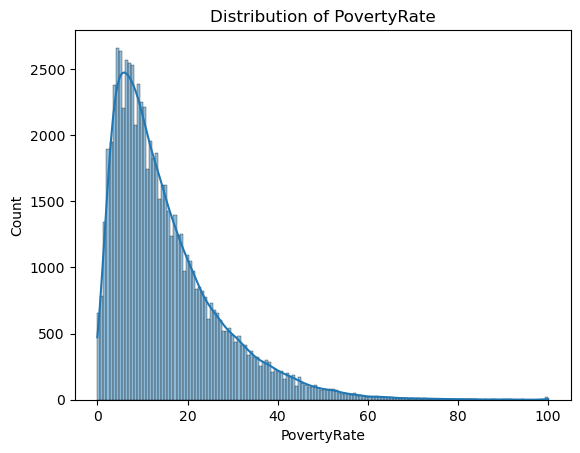

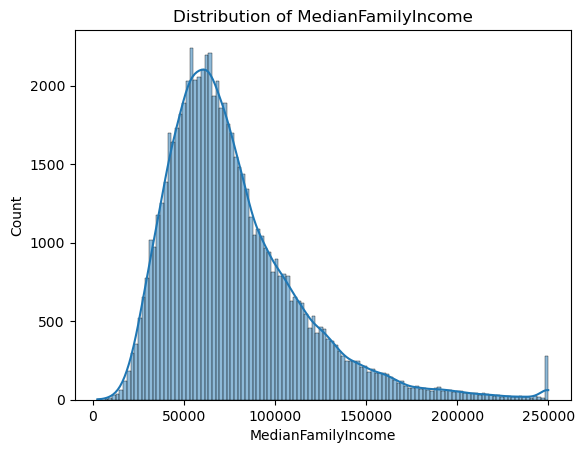

In [4]:
# Summary statistics
print(df.describe())

# Distribution of key features
for column in ['Pop2010', 'PovertyRate', 'MedianFamilyIncome']:
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

# Feature Engineering

Choosing features that are relevant to the problem at hand and engineering new features that will help in the analysis.

In [5]:
county_aggregation = df.groupby(['State', 'County']).agg({
    'Pop2010': 'sum',  # Total population per county
    'OHU2010': 'sum',  # Total occupied housing units per county
    'PovertyRate': 'mean',  # Average poverty rate per county
    'MedianFamilyIncome': 'mean',  # Average median family income per county
    'LowIncomeTracts': 'sum',  # Sum of low-income tracts per county
    'LILATracts_1And10': 'sum',  # Sum of low-income and low-access tracts per county
    'LALOWI1_10': 'sum',  # Total low-income population with low access at 1 & 10 miles
    'TractSNAP': 'sum'  # Total housing units receiving SNAP benefits
}).reset_index()

# Preview the corrected aggregated data
county_aggregation.head()

,State,County,Pop2010,OHU2010,PovertyRate,MedianFamilyIncome,LowIncomeTracts,LILATracts_1And10,LALOWI1_10,TractSNAP
0,Alabama,Autauga County,54571,20221,16.125000,69337.500000,5,5,7106.0,2692.0
1,Alabama,Baldwin County,182265,73180,11.845161,72665.741935,7,4,14468.0,5926.0
2,Alabama,Barbour County,27457,9820,29.311111,44792.444444,8,4,2864.0,2516.0
3,Alabama,Bibb County,22915,7953,12.175000,60645.500000,1,0,102.0,849.0
4,Alabama,Blount County,57322,21578,14.855556,60437.666667,3,0,1440.0,1966.0


Distribution of Median Family Income across Counties
Relationship between Poverty Rates and Low-Access Indicators across Counties
Low-Income, Low-Access tracts by State

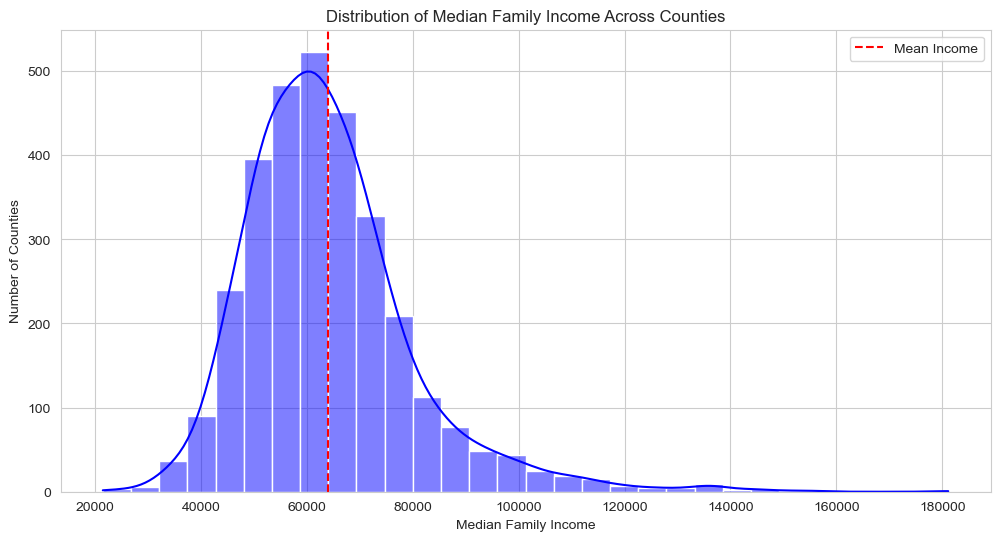

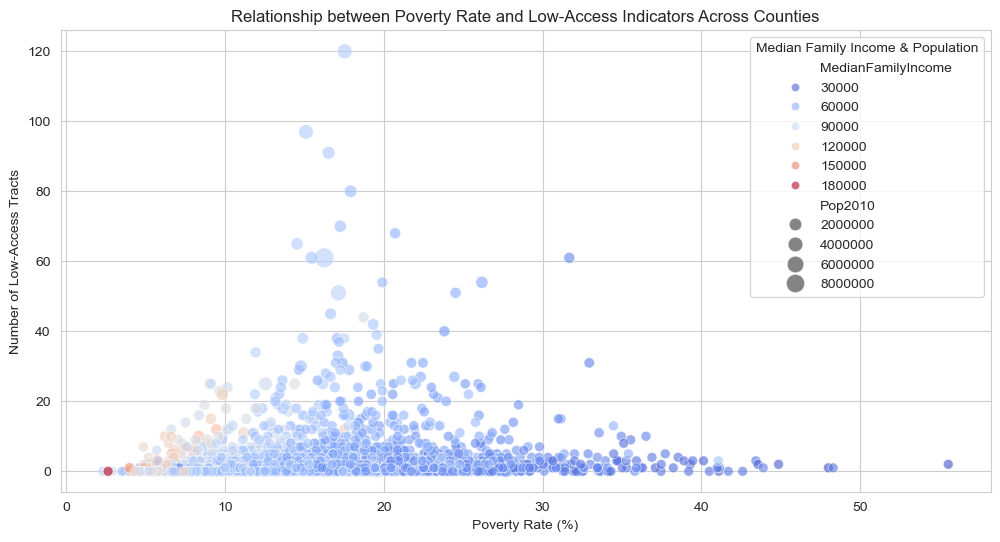

/var/folders/67/7hn0hf594mx1nr3d4zql8fg80000gn/T/ipykernel_30200/1053385113.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_grouped, x='LILATracts_1And10', y='State', palette='viridis')


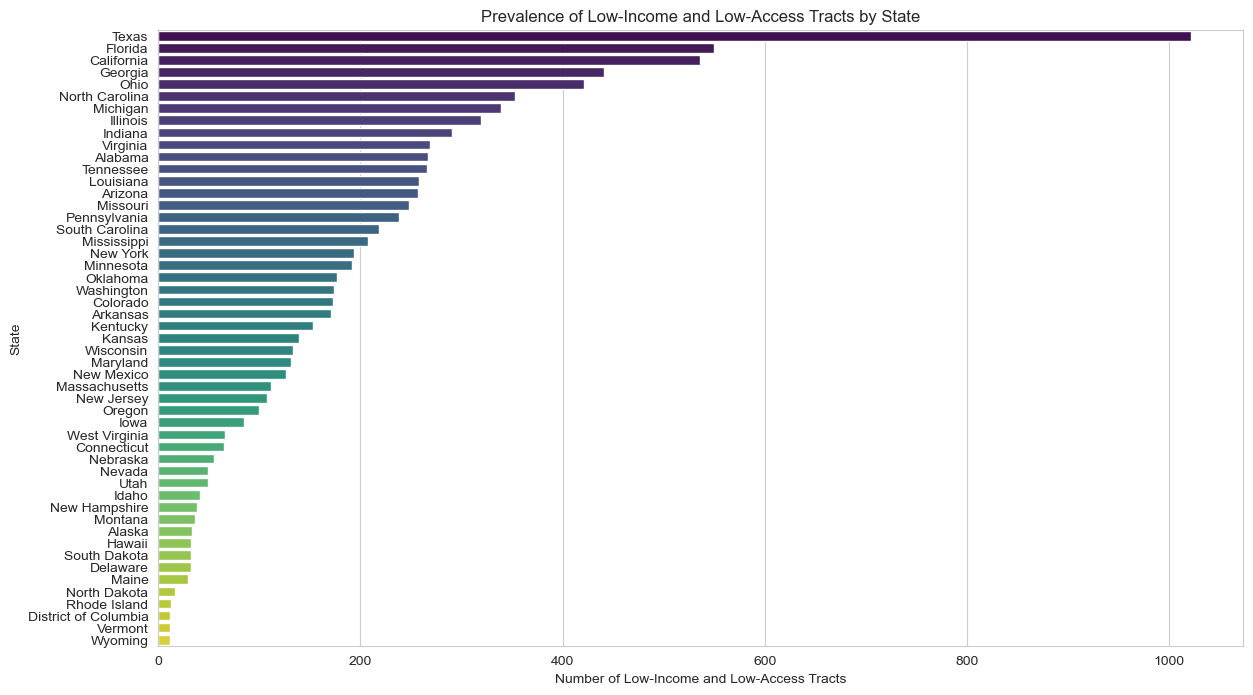

In [8]:
# Set the style of the plots
sns.set_style("whitegrid")

# Visualization 1: Distribution of Median Family Income across Counties
plt.figure(figsize=(12, 6))
sns.histplot(county_aggregation['MedianFamilyIncome'], bins=30, kde=True, color='blue')
plt.title('Distribution of Median Family Income Across Counties')
plt.xlabel('Median Family Income')
plt.ylabel('Number of Counties')
plt.axvline(county_aggregation['MedianFamilyIncome'].mean(), color='red', linestyle='--', label='Mean Income')
plt.legend()
plt.show()

# Visualization 2: Relationship between Poverty Rates and Low-Access Indicators across Counties
plt.figure(figsize=(12, 6))
sns.scatterplot(data=county_aggregation, x='PovertyRate', y='LILATracts_1And10', hue='MedianFamilyIncome', size='Pop2010', sizes=(50, 200), alpha=0.6, palette="coolwarm")
plt.title('Relationship between Poverty Rate and Low-Access Indicators Across Counties')
plt.xlabel('Poverty Rate (%)')
plt.ylabel('Number of Low-Access Tracts')
plt.legend(title='Median Family Income & Population', loc='upper right')
plt.grid(True)
plt.show()

# Visualization 3: Prevalence of Low-Income and Low-Access Tracts by State

# Aggregating by state for this visualization
state_grouped = county_aggregation.groupby('State').agg({
    'LowIncomeTracts': 'sum',
    'LILATracts_1And10': 'sum'
}).reset_index()

plt.figure(figsize=(14, 8))
state_grouped = state_grouped.sort_values('LILATracts_1And10', ascending=False)
sns.barplot(data=state_grouped, x='LILATracts_1And10', y='State', palette='viridis')
plt.title('Prevalence of Low-Income and Low-Access Tracts by State')
plt.xlabel('Number of Low-Income and Low-Access Tracts')
plt.ylabel('State')
plt.show();


There may be more features that can be engineered from the data. I will explore the data and see if there are any features that can be engineered from the data.

In [11]:
# Update the aggregation to include new features
county_aggregation = df.groupby(['State', 'County']).agg({
    'Pop2010': 'sum', # Total population per county
    'OHU2010': 'sum', # Total occupied housing units per county
    'PovertyRate': 'mean',  # Average poverty rate per county
    'MedianFamilyIncome': 'mean',  # Average median family income per county
    'LowIncomeTracts': 'sum',  # Sum of low-income tracts per county
    'LILATracts_1And10': 'sum',  # Sum of low-income and low-access tracts per county
    'LALOWI1_10': 'sum',  # Total low-income population with low access at 1 & 10 miles
    'TractSNAP': 'sum',  # Total housing units receiving SNAP benefits
    'TractHUNV': 'sum',  # Total housing units without a vehicle
    'lapop1': 'sum',  # Population beyond 1 mile from a supermarket
    'lapop10': 'sum',  # Population beyond 10 miles from a supermarket
    'TractKids': 'sum',  # Total count of children age 0-17
    'TractSeniors': 'sum',  # Total count of seniors age 65+
    'TractWhite': 'sum',  # Total count of White population
    'TractBlack': 'sum',  # Total count of Black or African American population
    'TractAsian': 'sum',  # Total count of Asian population
    'TractHispanic': 'sum'  # Total count of Hispanic or Latino population
}).reset_index()

# Add percentage columns for households without a vehicle and demographic breakdowns
county_aggregation['PctHUNV'] = (county_aggregation['TractHUNV'] / county_aggregation['OHU2010']) * 100
county_aggregation['PctKids'] = (county_aggregation['TractKids'] / county_aggregation['Pop2010']) * 100
county_aggregation['PctSeniors'] = (county_aggregation['TractSeniors'] / county_aggregation['Pop2010']) * 100
county_aggregation['PctWhite'] = (county_aggregation['TractWhite'] / county_aggregation['Pop2010']) * 100
county_aggregation['PctBlack'] = (county_aggregation['TractBlack'] / county_aggregation['Pop2010']) * 100
county_aggregation['PctAsian'] = (county_aggregation['TractAsian'] / county_aggregation['Pop2010']) * 100
county_aggregation['PctHispanic'] = (county_aggregation['TractHispanic'] / county_aggregation['Pop2010']) * 100

# Preview the updated county aggregation
county_aggregation.head()


,State,County,Pop2010,OHU2010,PovertyRate,MedianFamilyIncome,LowIncomeTracts,LILATracts_1And10,LALOWI1_10,TractSNAP,...,TractBlack,TractAsian,TractHispanic,PctHUNV,PctKids,PctSeniors,PctWhite,PctBlack,PctAsian,PctHispanic
0,Alabama,Autauga County,54571,20221,16.125000,69337.500000,5,5,7106.0,2692.0,...,9643.0,474.0,1310.0,5.889916,26.777959,11.995382,78.530721,17.670558,0.868593,2.400542
1,Alabama,Baldwin County,182265,73180,11.845161,72665.741935,7,4,14468.0,5926.0,...,17105.0,1348.0,7992.0,3.696365,22.987408,16.771185,85.673607,9.384687,0.739582,4.384824
2,Alabama,Barbour County,27457,9820,29.311111,44792.444444,8,4,2864.0,2516.0,...,12875.0,107.0,1387.0,8.645621,21.906982,14.236807,48.002331,46.891503,0.389700,5.051535
3,Alabama,Bibb County,22915,7953,12.175000,60645.500000,1,0,102.0,849.0,...,5047.0,22.0,406.0,5.155287,22.696923,12.681650,75.849880,22.024875,0.096007,1.771765
4,Alabama,Blount County,57322,21578,14.855556,60437.666667,3,0,1440.0,1966.0,...,761.0,117.0,4626.0,3.967003,24.608353,14.722096,92.578766,1.327588,0.204110,8.070200


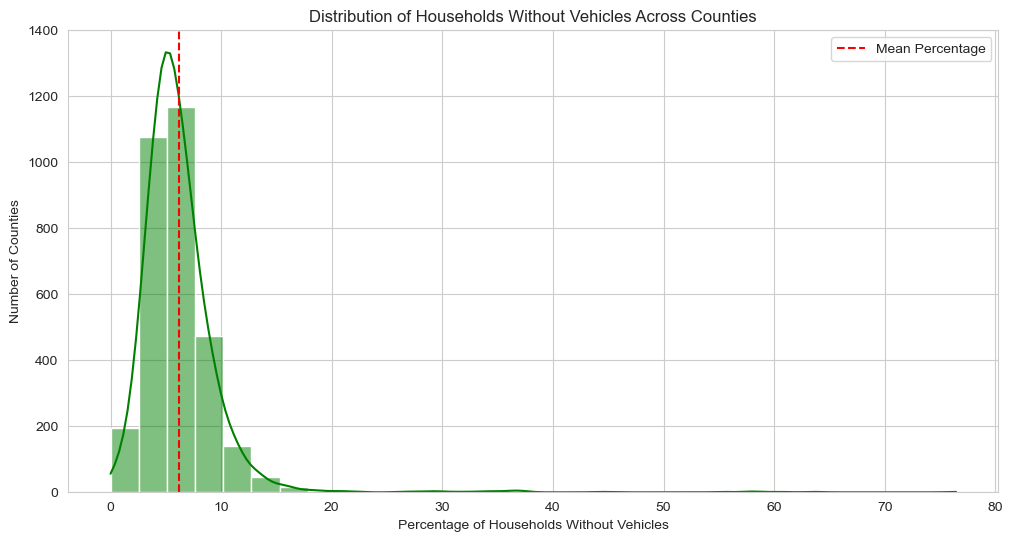

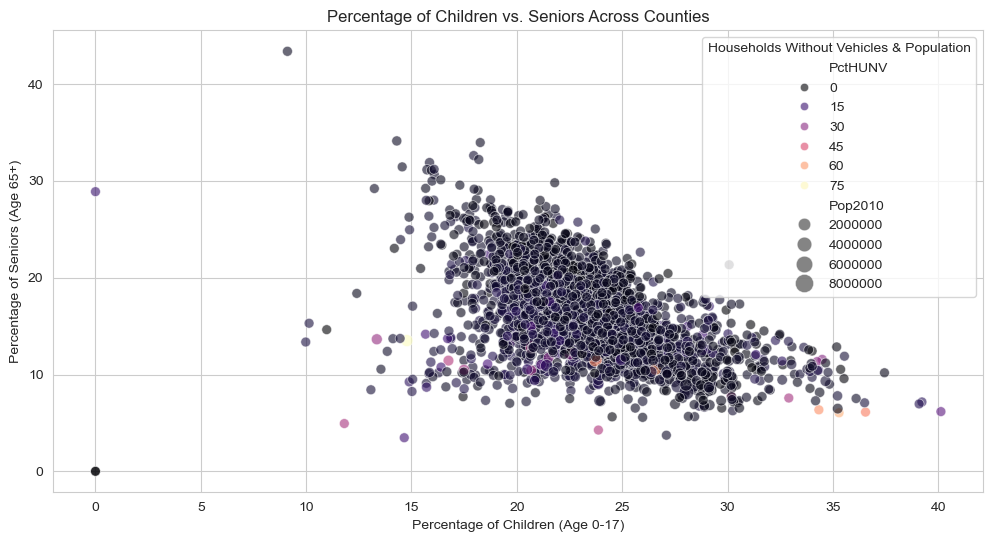

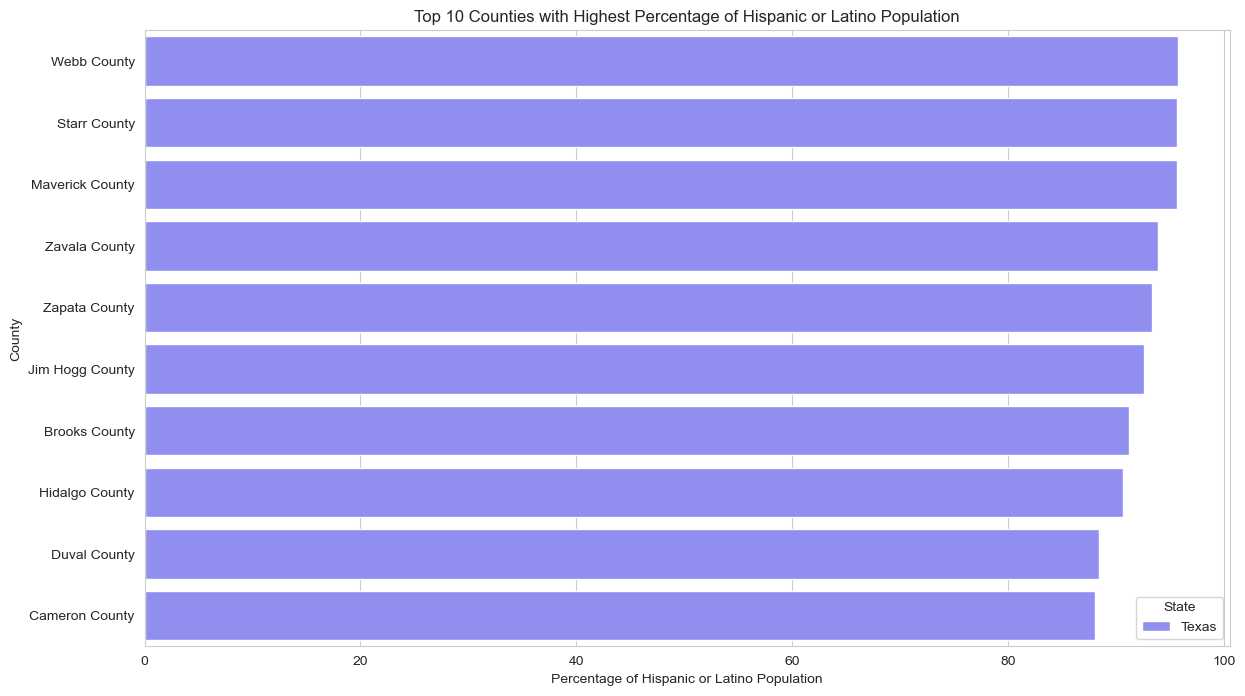

In [12]:
# Visualization 4: Percentage of Households Without Vehicles Across Counties
plt.figure(figsize=(12, 6))
sns.histplot(county_aggregation['PctHUNV'], bins=30, kde=True, color='green')
plt.title('Distribution of Households Without Vehicles Across Counties')
plt.xlabel('Percentage of Households Without Vehicles')
plt.ylabel('Number of Counties')
plt.axvline(county_aggregation['PctHUNV'].mean(), color='red', linestyle='--', label='Mean Percentage')
plt.legend()
plt.show()

# Visualization 5: Demographic Breakdown - Children and Seniors
plt.figure(figsize=(12, 6))
sns.scatterplot(data=county_aggregation, x='PctKids', y='PctSeniors', hue='PctHUNV', size='Pop2010', sizes=(50, 200), palette="magma", alpha=0.6)
plt.title('Percentage of Children vs. Seniors Across Counties')
plt.xlabel('Percentage of Children (Age 0-17)')
plt.ylabel('Percentage of Seniors (Age 65+)')
plt.legend(title='Households Without Vehicles & Population', loc='upper right')
plt.grid(True)
plt.show()

# Visualization 6: Racial/Ethnic Composition - Percentage of Hispanic or Latino Population
plt.figure(figsize=(14, 8))
sns.barplot(data=county_aggregation.sort_values('PctHispanic', ascending=False).head(10), x='PctHispanic', y='County', hue='State', dodge=False, palette='cool')
plt.title('Top 10 Counties with Highest Percentage of Hispanic or Latino Population')
plt.xlabel('Percentage of Hispanic or Latino Population')
plt.ylabel('County')
plt.legend(title='State', loc='lower right')
plt.show()


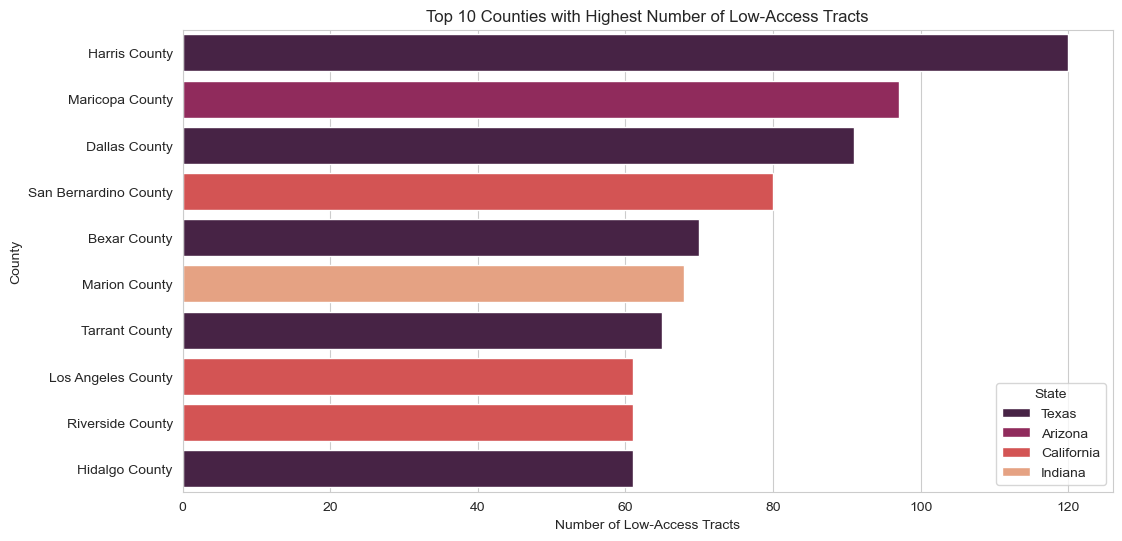

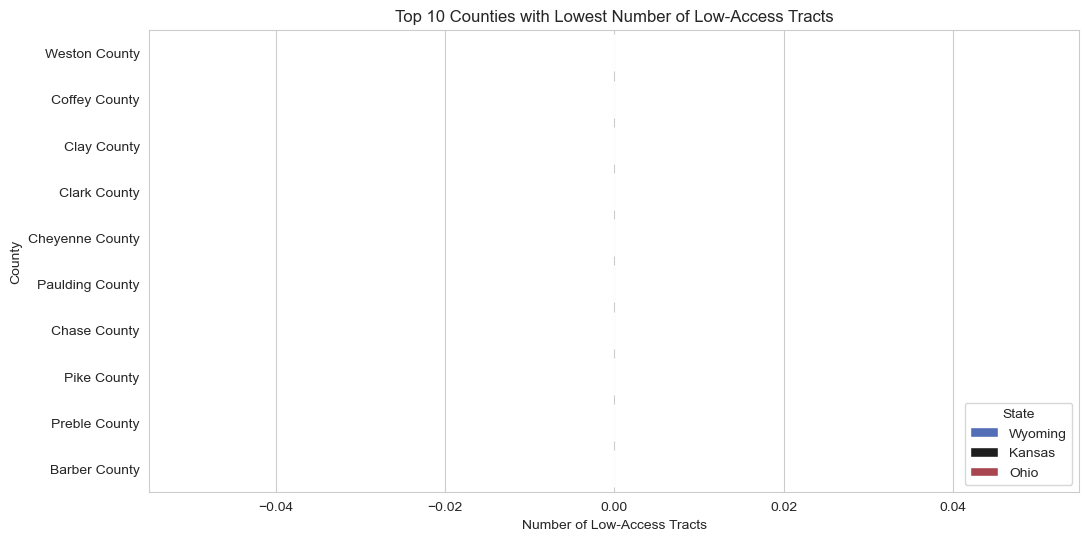

In [13]:
# Identifying counties with the highest and lowest number of low-access tracts
highest_low_access = county_aggregation.sort_values('LILATracts_1And10', ascending=False).head(10)
lowest_low_access = county_aggregation.sort_values('LILATracts_1And10', ascending=True).head(10)

# Visualization 10: Highest Low-Access Tracts
plt.figure(figsize=(12, 6))
sns.barplot(data=highest_low_access, x='LILATracts_1And10', y='County', hue='State', dodge=False, palette='rocket')
plt.title('Top 10 Counties with Highest Number of Low-Access Tracts')
plt.xlabel('Number of Low-Access Tracts')
plt.ylabel('County')
plt.legend(title='State', loc='lower right')
plt.show()

# Visualization 11: Lowest Low-Access Tracts
plt.figure(figsize=(12, 6))
sns.barplot(data=lowest_low_access, x='LILATracts_1And10', y='County', hue='State', dodge=False, palette='icefire')
plt.title('Top 10 Counties with Lowest Number of Low-Access Tracts')
plt.xlabel('Number of Low-Access Tracts')
plt.ylabel('County')
plt.legend(title='State', loc='lower right')
plt.show()


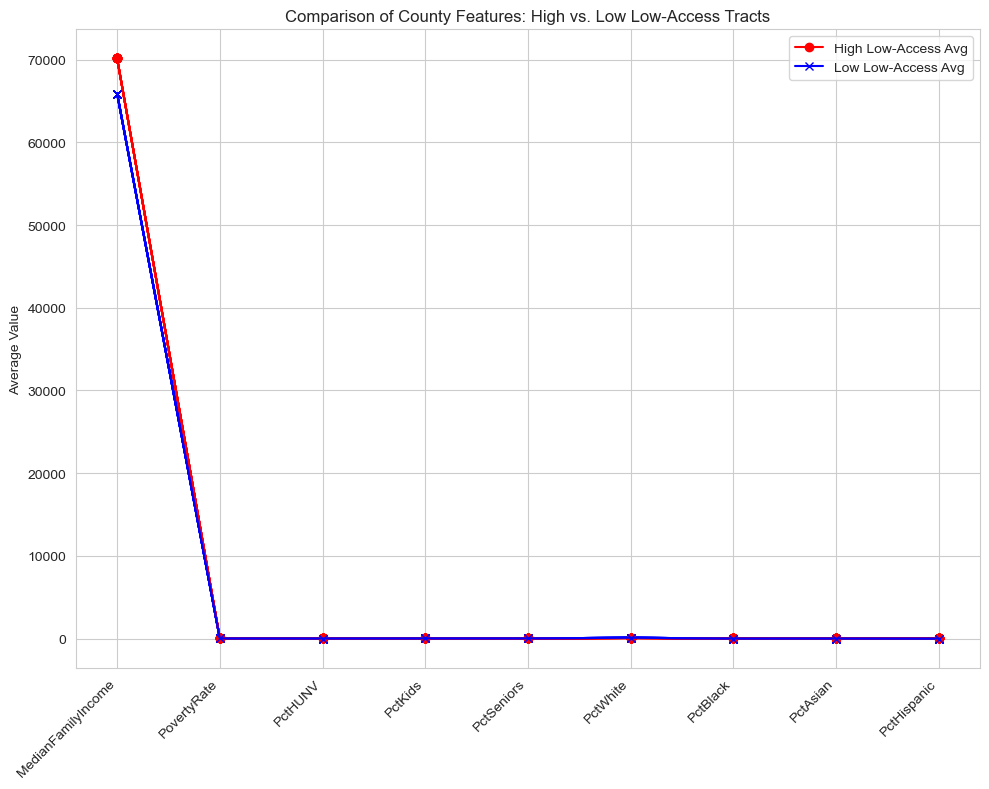

In [19]:
# Summary statistics for counties with the highest and lowest number of low-access tracts
features = ['MedianFamilyIncome', 'PovertyRate', 'PctHUNV', 'PctKids', 'PctSeniors', 'PctWhite', 'PctBlack', 'PctAsian', 'PctHispanic']
summary_high = highest_low_access[features].mean().reset_index()
summary_low = lowest_low_access[features].mean().reset_index()

summary_high.columns = ['Feature', 'High Low-Access Avg']
summary_low.columns = ['Feature', 'Low Low-Access Avg']

# Merging the summaries for comparison
summary_comparison = pd.merge(summary_high, summary_low, on='Feature')

# Visualization: Comparing Features of High vs. Low Low-Access Tracts Counties
plt.figure(figsize=(10, 8))
for feature in features:
    plt.plot(summary_comparison['Feature'], summary_comparison['High Low-Access Avg'], label='High Low-Access Avg', color='red', marker='o')
    plt.plot(summary_comparison['Feature'], summary_comparison['Low Low-Access Avg'], label='Low Low-Access Avg', color='blue', marker='x')
    plt.legend(["High Low-Access Avg", "Low Low-Access Avg"])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel('Average Value')
    plt.title('Comparison of County Features: High vs. Low Low-Access Tracts')
    plt.tight_layout()

plt.show()


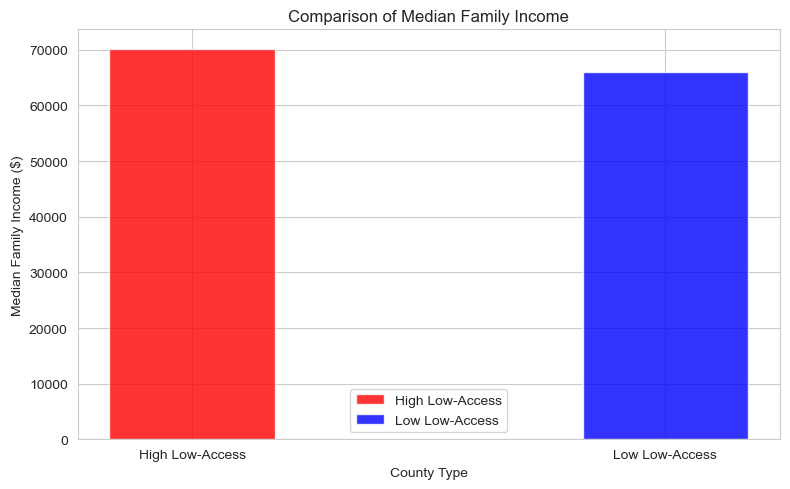

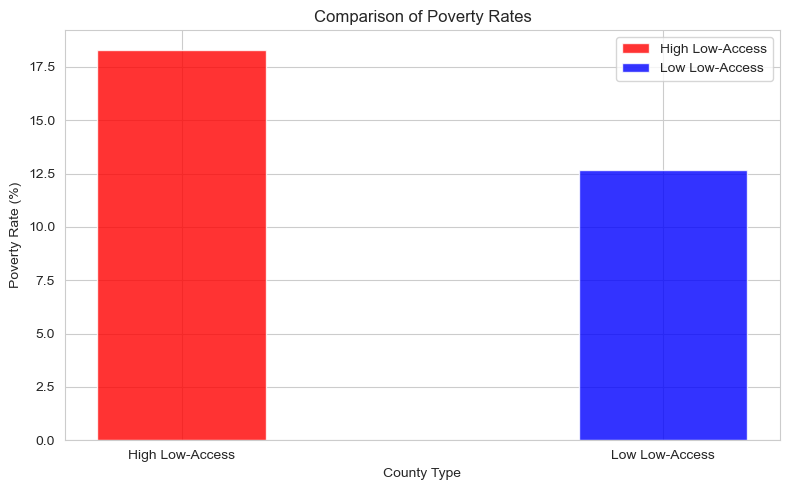

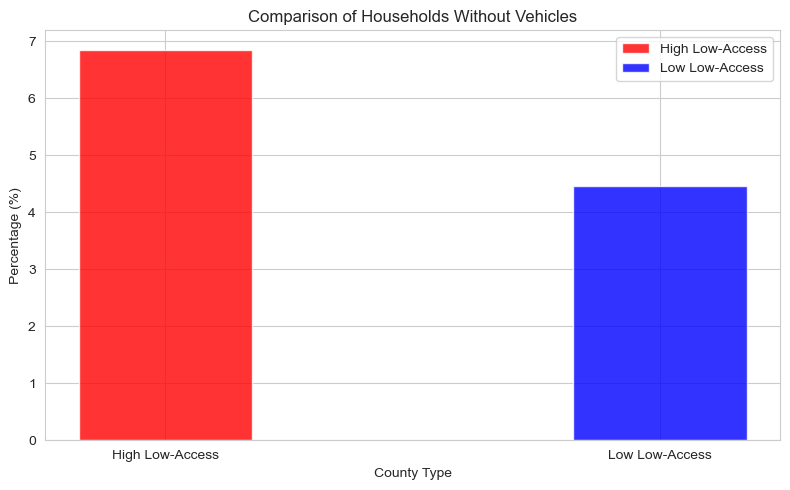

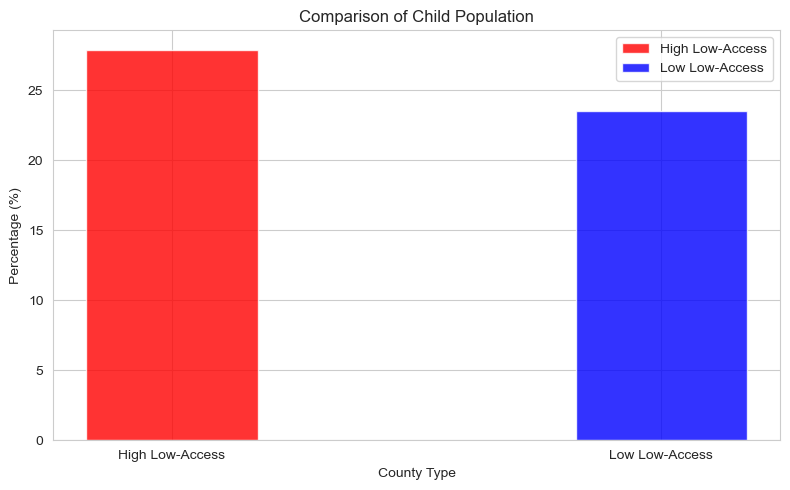

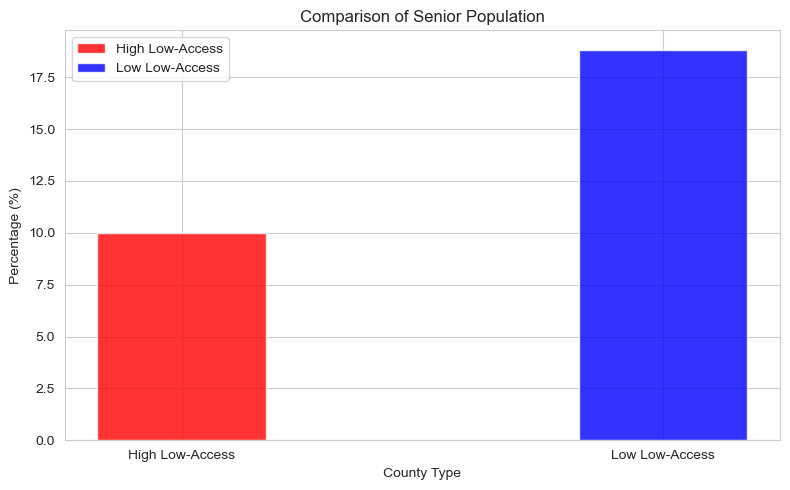

In [20]:
# Let's create individual visualizations for a clearer comparison between the features of high vs. low low-access tract counties.

# Function to create side-by-side bar plots for comparison
def plot_feature_comparison(feature, title, y_label):
    fig, ax = plt.subplots(figsize=(8, 5))
    index = np.arange(2)
    bar_width = 0.35
    opacity = 0.8

    values = [summary_comparison[summary_comparison['Feature'] == feature]['High Low-Access Avg'].values[0],
              summary_comparison[summary_comparison['Feature'] == feature]['Low Low-Access Avg'].values[0]]

    rects1 = plt.bar(index, values, bar_width,
                     alpha=opacity,
                     color=['red', 'blue'],
                     label=['High Low-Access', 'Low Low-Access'])

    plt.xlabel('County Type')
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(index, ['High Low-Access', 'Low Low-Access'])
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot comparisons for selected features
plot_feature_comparison('MedianFamilyIncome', 'Comparison of Median Family Income', 'Median Family Income ($)')
plot_feature_comparison('PovertyRate', 'Comparison of Poverty Rates', 'Poverty Rate (%)')
plot_feature_comparison('PctHUNV', 'Comparison of Households Without Vehicles', 'Percentage (%)')
plot_feature_comparison('PctKids', 'Comparison of Child Population', 'Percentage (%)')
plot_feature_comparison('PctSeniors', 'Comparison of Senior Population', 'Percentage (%)')


# Modeling

## Random Forest Classifier